In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy
import datetime
import numpy as np

In [17]:
from qfin.models import *
from qfin.vs import from_tickers

In [47]:
models = BlackScholesModel, HestonModel, VarianceGammaModel, SVJModel, SVCJModel, CGMYModel, MertonModel

In [50]:
DIRECTORY = "20210227_195345"

In [51]:
def obtain_market_data(fname, model):
    fname = f"_output/calibration/results/{DIRECTORY}/{model.name}/errors/{fname}"
    df = pd.read_csv(fname)
    return df[['diff']]

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = float(se * scipy.stats.t.ppf((1 + confidence) / 2., n-1))
    return m, m - h, m + h

In [52]:
model = models[0]
df = pd.read_csv(f'_output/calibration/results/{DIRECTORY}/{model.name}/parameters.csv')
np.min(df.loc[:, model.labels].min())

0.5013310000000001

In [56]:
def plot_parameters(model):
        
    df = pd.read_csv(f'_output/calibration/results/{DIRECTORY}/{model.name}/parameters.csv')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df = df.set_index('date')
    
    fig, axs = plt.subplots(figsize=(15, 4), ncols=3)
    
    df1 = df[(df.index >= '2019-04-01') & (df.index < '2019-10-01')]
    df2 = df[(df.index >= '2019-10-01') & (df.index < '2020-02-01')]
    df3 = df[(df.index >= '2020-02-01') & (df.index < '2020-07-01')]
    
    m0 = np.min(df.loc[:, model.labels].min())
    m1 = np.max(df.loc[:, model.labels].max())
    
    m0 -= 0.1 * np.abs(m0)
    m1 += 0.1 * np.abs(m1)
        
    for ax, df in zip(axs, [df1, df2, df3]):
        # ax.set_title(f"PARAMETERS {model.name}")
        for label in model.labels:
            df[label].plot(ax=ax)
            ax.set_ylim((m0, m1))
            
    path = f"_output/calibration/figures/PARAMETERS__{model.name}.pdf"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path)

In [58]:
def plot_rmse(model):
    
    dirname = f"_output/calibration/results/{DIRECTORY}/{model.name}/errors/"
    files = sorted([f for f in os.listdir(dirname) if f.endswith("csv")])
    
    data = [mean_confidence_interval(obtain_market_data(f, model), confidence=0.95) for f in files]
    dates = [datetime.datetime.strptime(f[:8], '%Y%m%d') for f in files]
    
    df = pd.DataFrame([[d, x[0], x[1], x[2]] for d, x in zip(dates, data)], columns=['date', 'rmse', 'lower', 'upper'])
    df = df.set_index('date')

    fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

    df1 = df[(df.index >= '2019-04-01') & (df.index < '2019-10-01')]
    df2 = df[(df.index >= '2019-10-01') & (df.index < '2020-02-01')]
    df3 = df[(df.index >= '2020-02-01') & (df.index < '2020-07-01')]
    
    for ax, df in zip(axs, [df1, df2, df3]):
        # ax.set_title(f"RMSE {model.name}")
        df['rmse'].plot(ax=ax, marker="o", color="red")
        df['lower'].plot(ax=ax, linestyle="dashed", color="#cccccc")
        df['upper'].plot(ax=ax, linestyle="dashed", color="#cccccc")

    path = f"_output/calibration/figures/RMSE__{model.name}.pdf"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path)

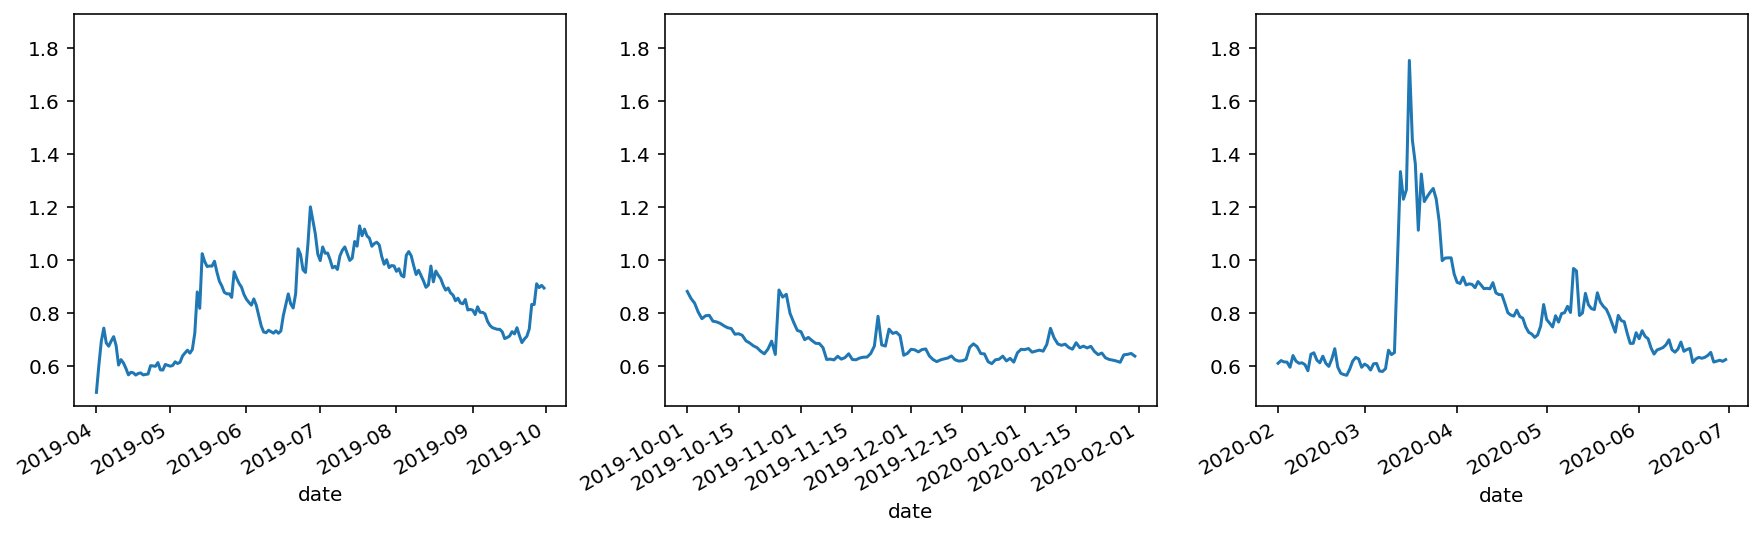

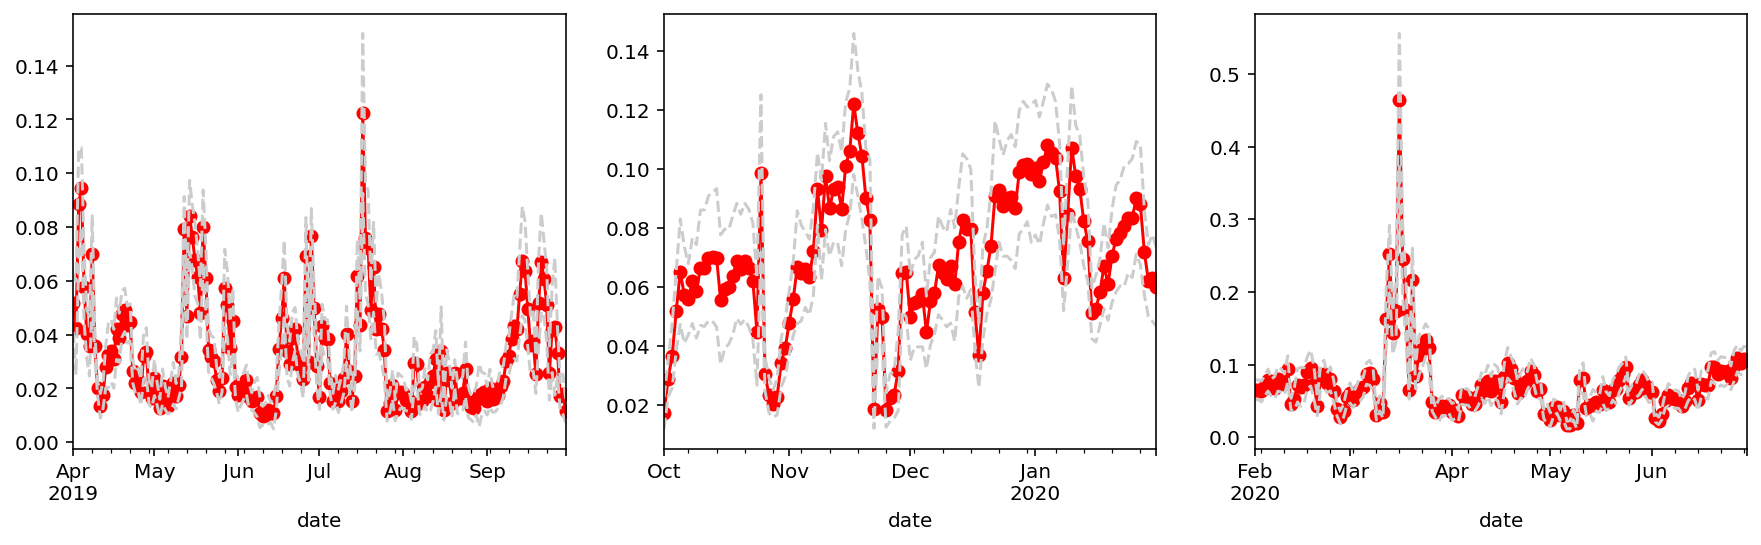

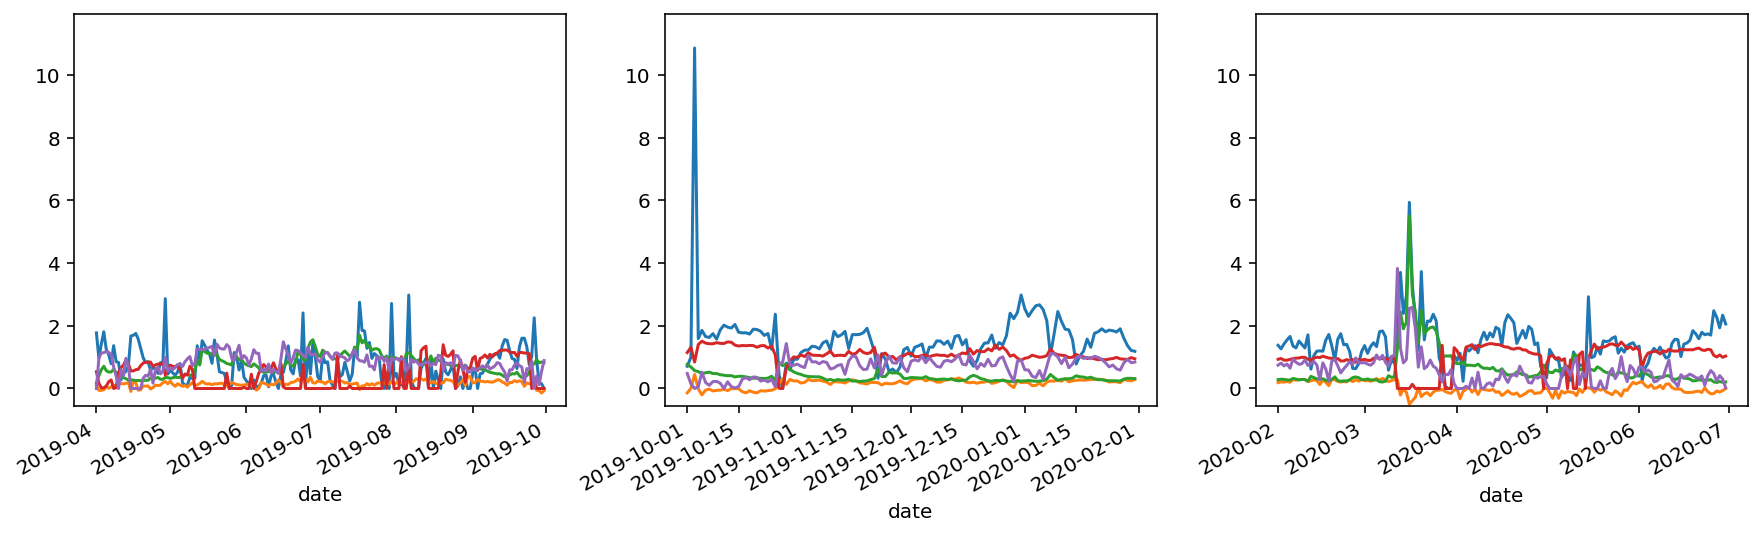

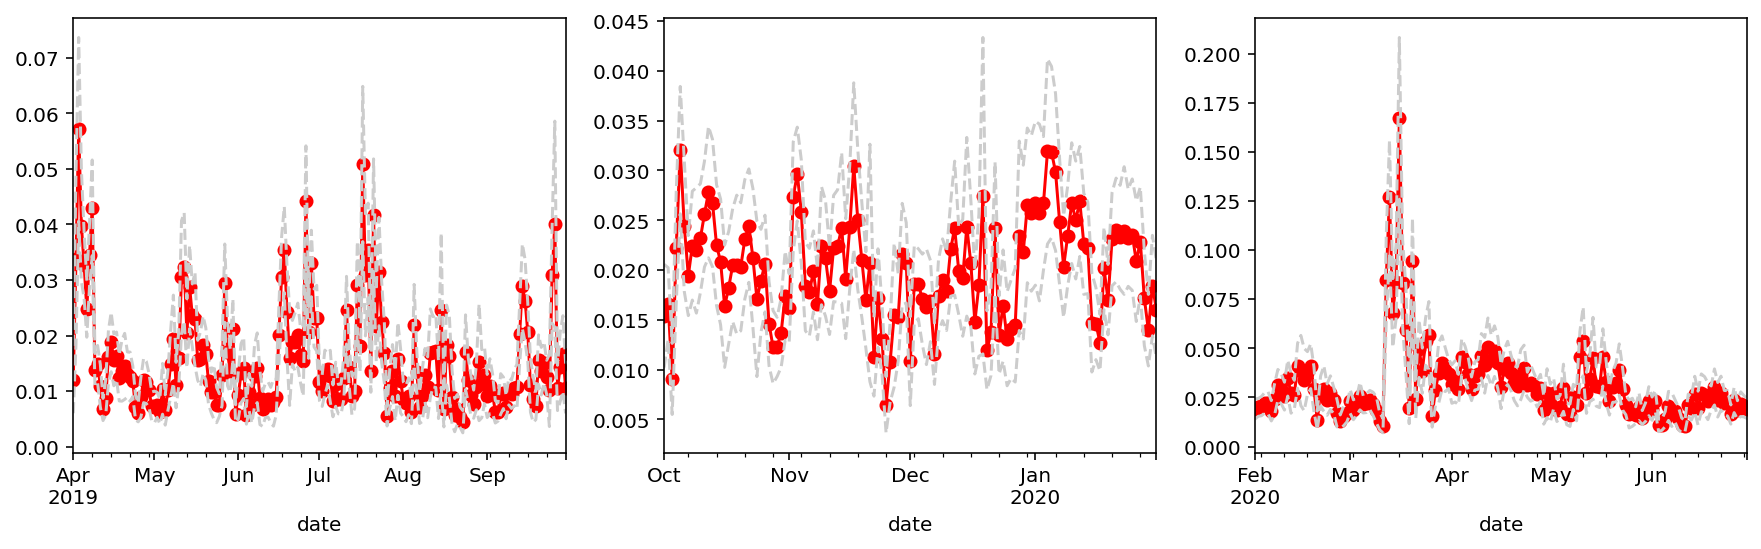

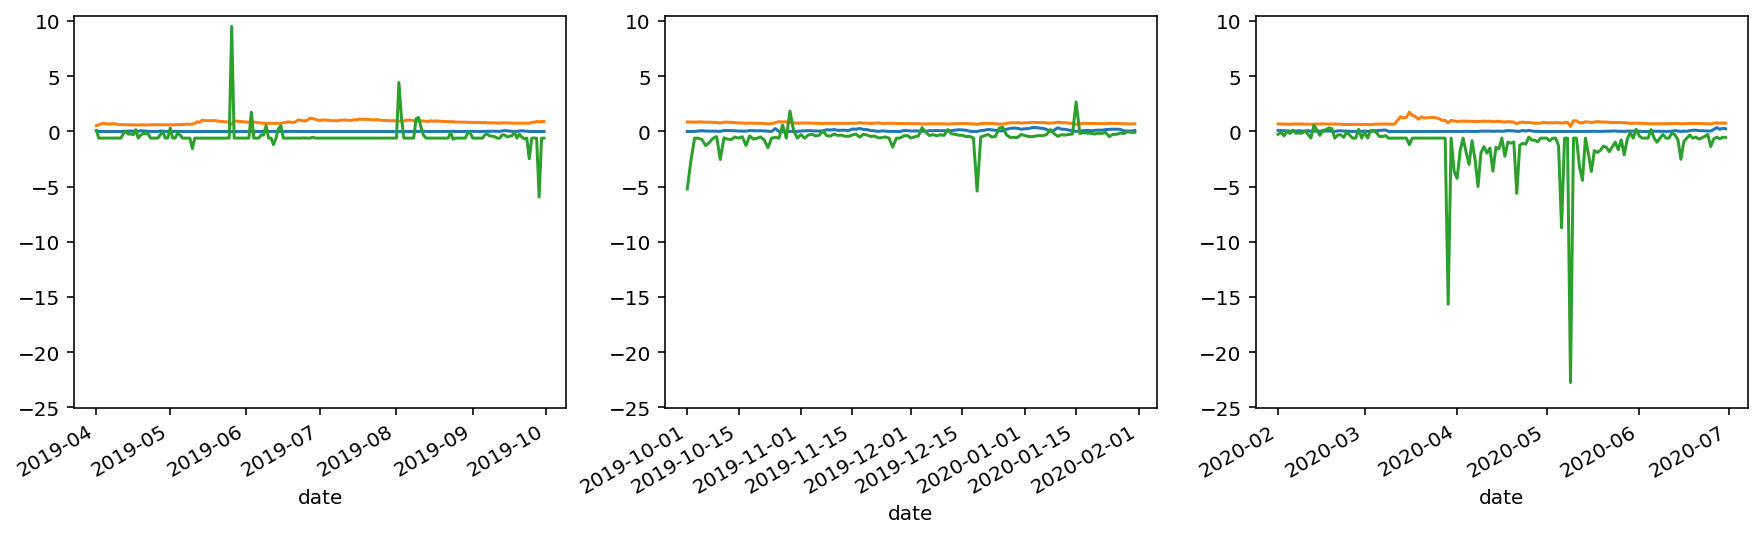

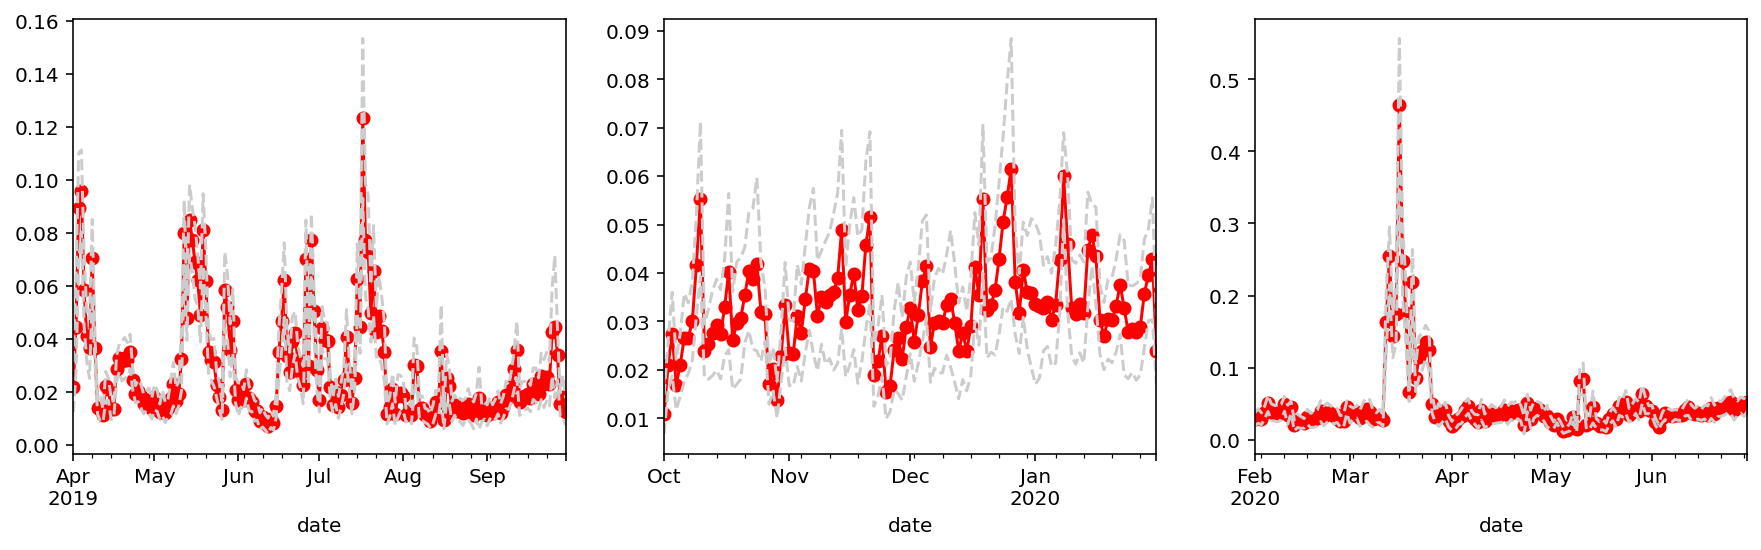

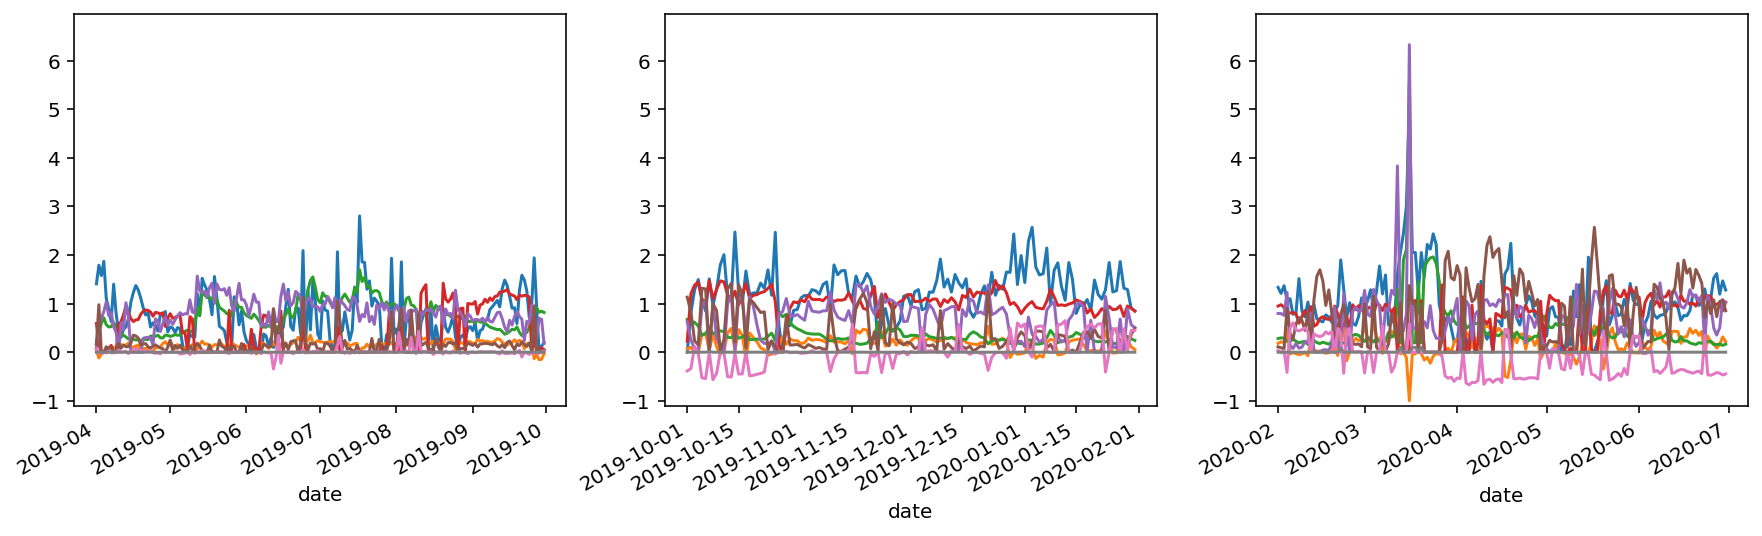

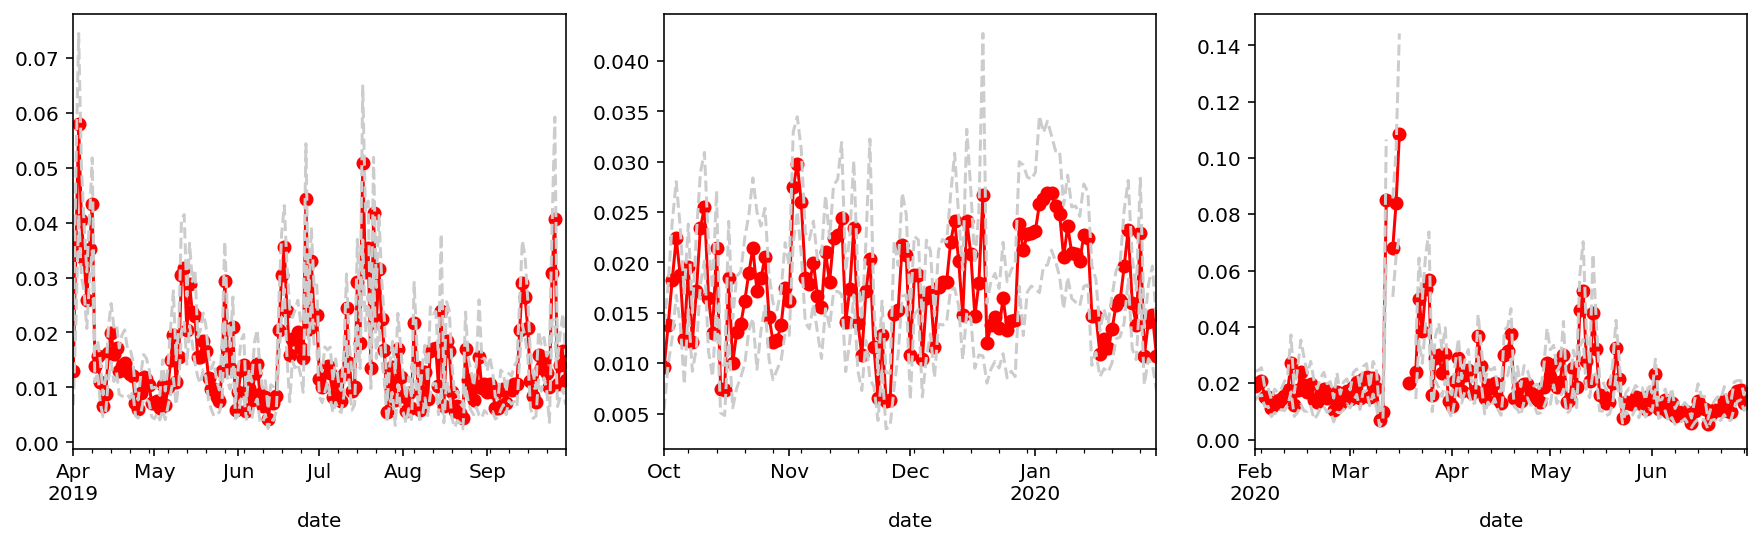

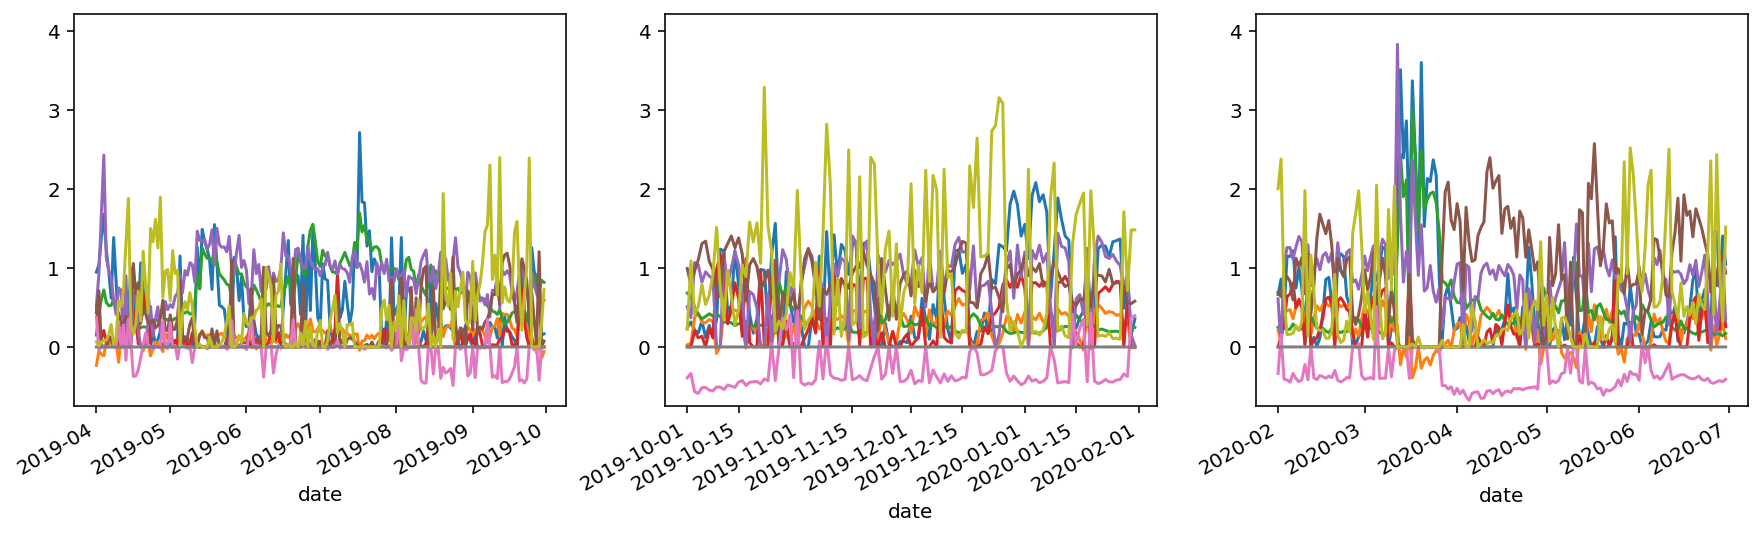

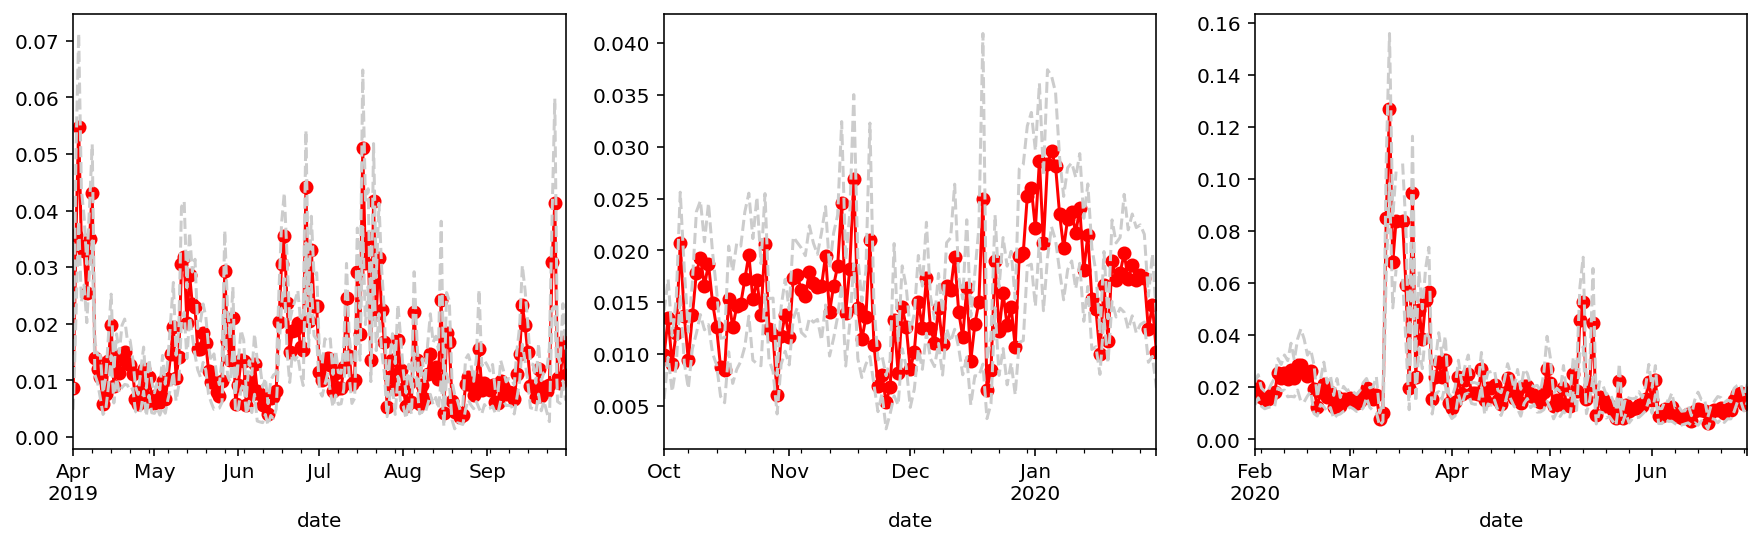

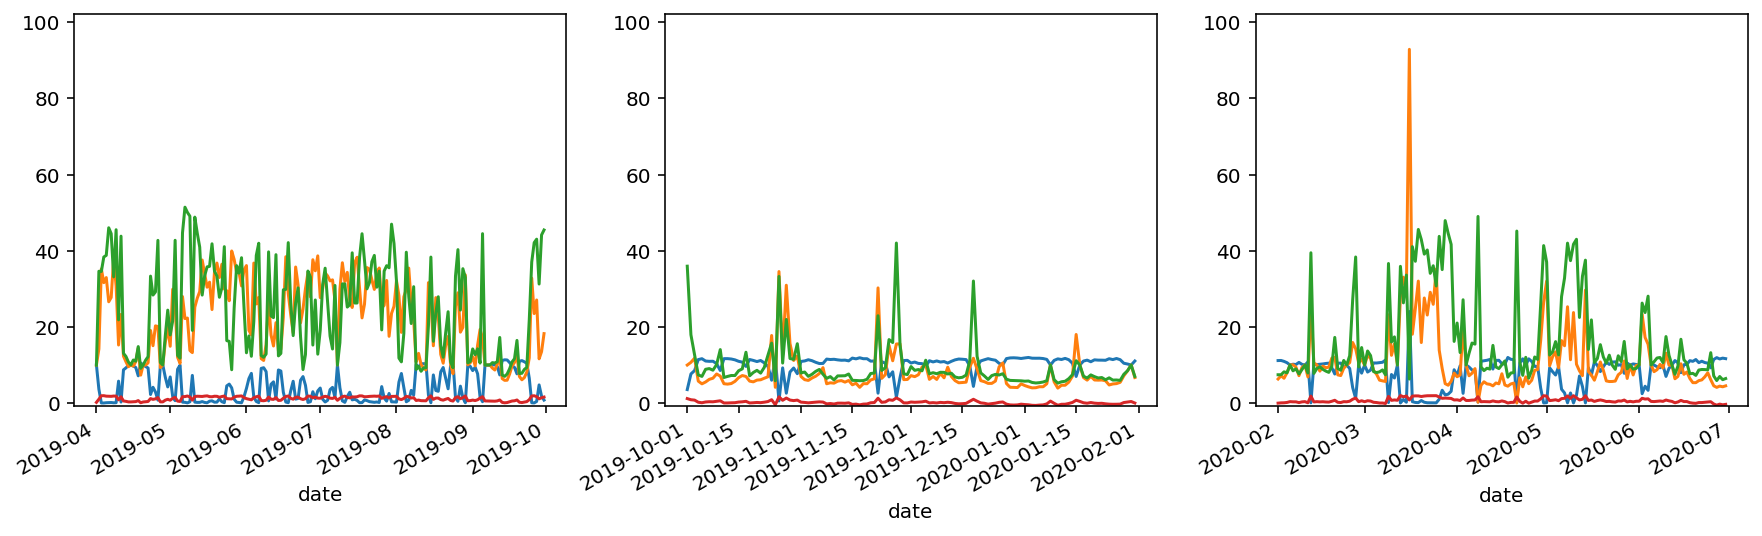

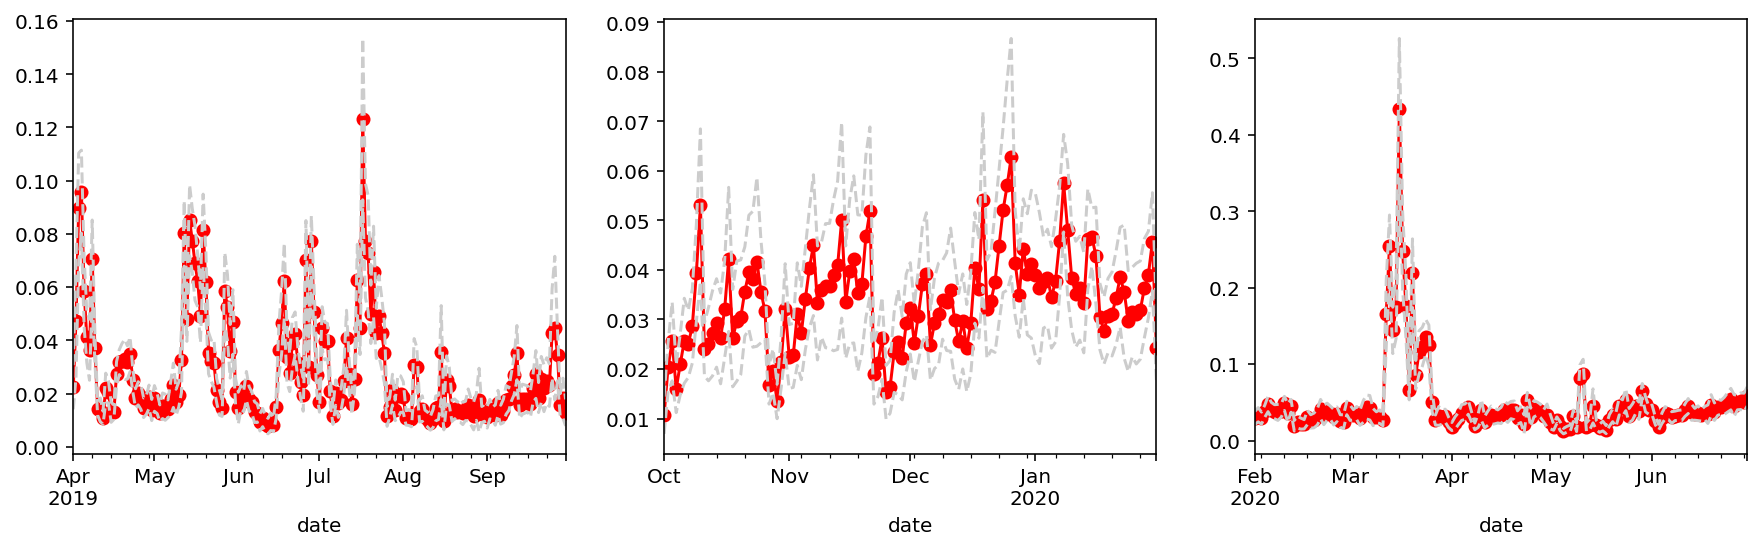

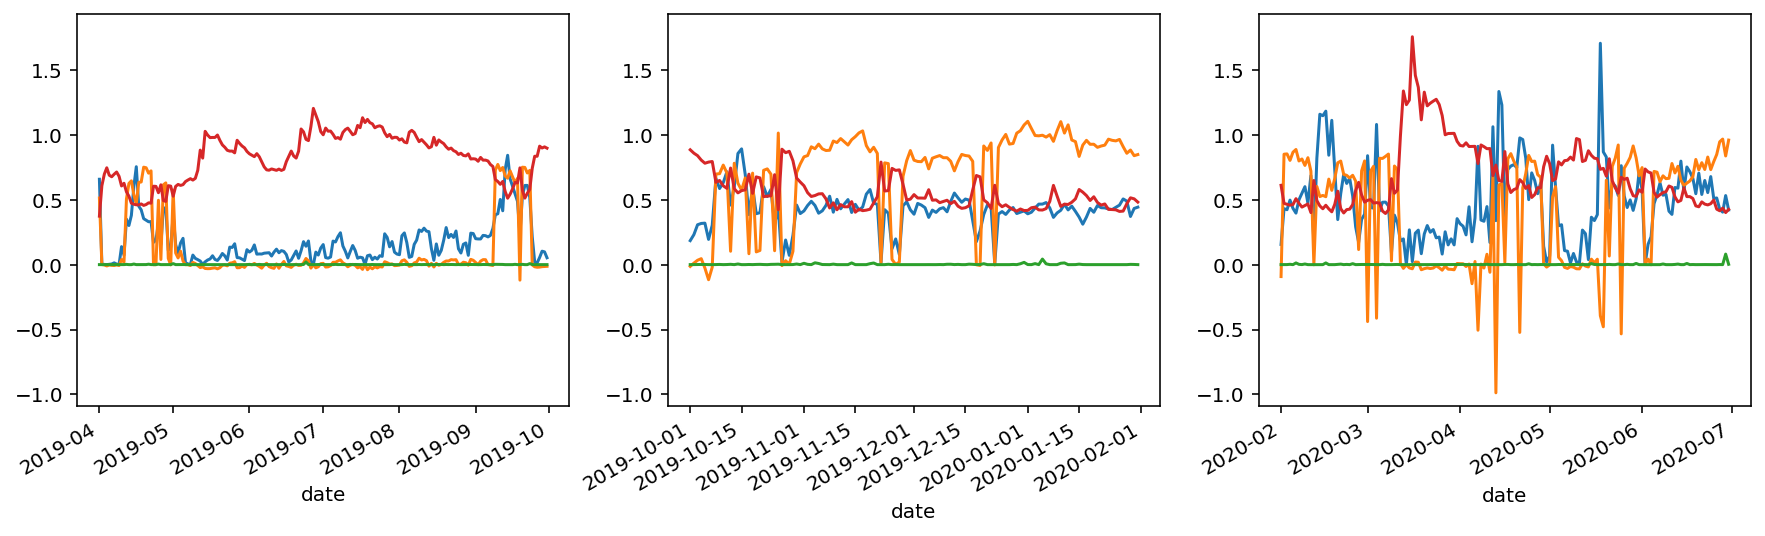

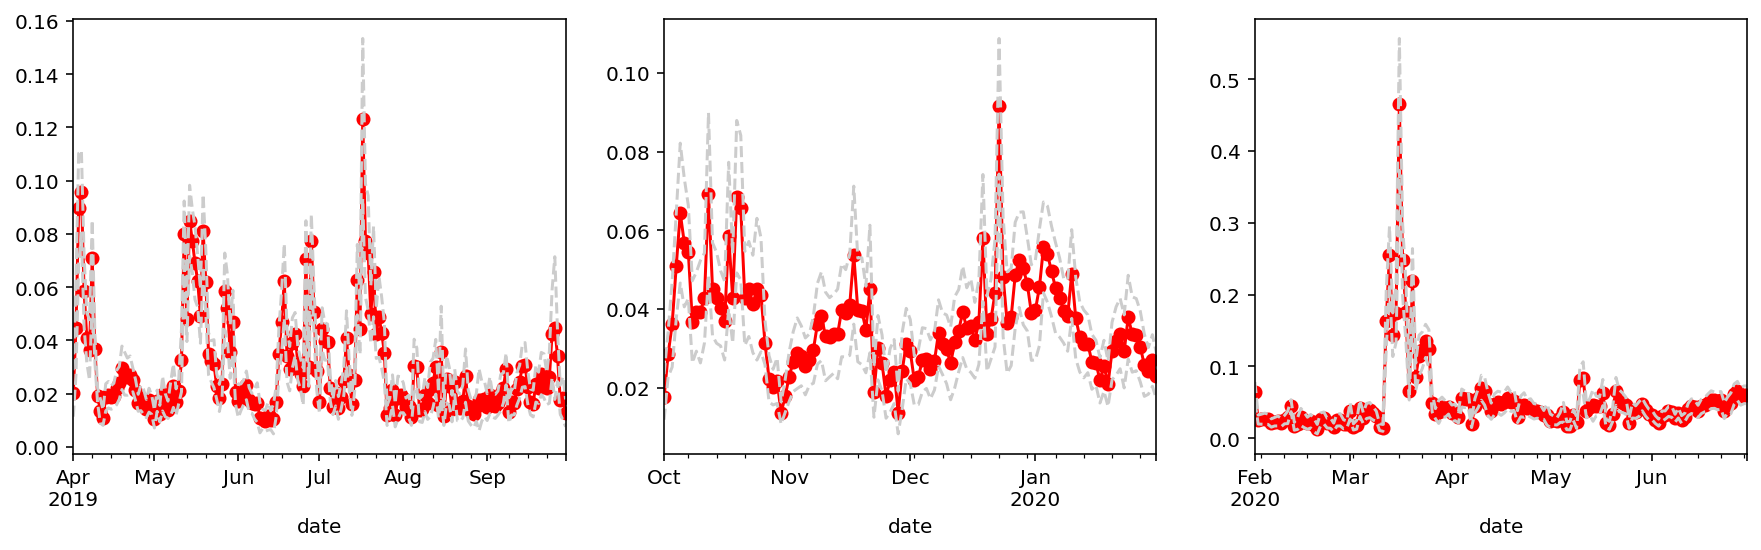

In [59]:
for model in models:
    plot_parameters(model)
    plot_rmse(model)